🔄 Training VAR Model...
✅ VAR model training complete! Model saved as 'model.pkl'.
📈 Generating 744-hour forecast using VAR...
✅ Predictions saved as 'predictions.csv'.


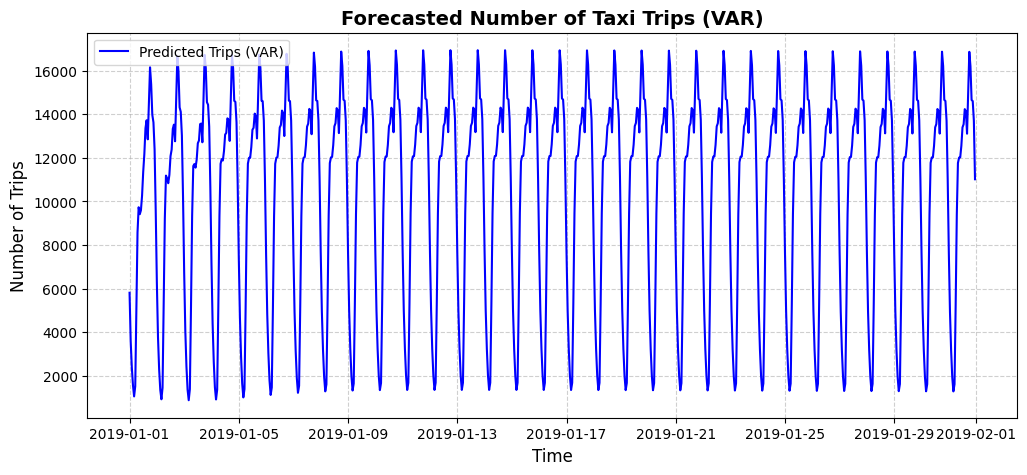

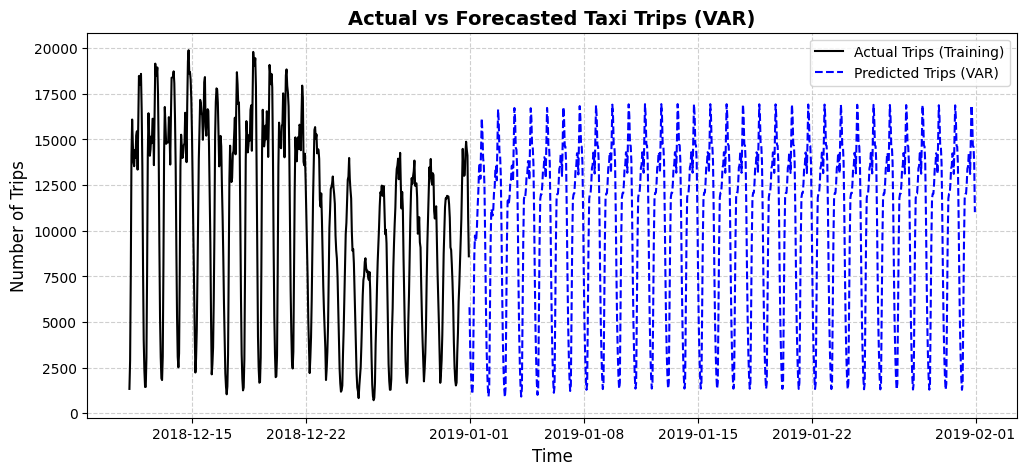

In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# =========================
# 📌 Load & Process Training Data
# =========================
train_url = "https://github.com/dustywhite7/econ8310-assignment1/raw/main/assignment_data_train.csv"
train_data = pd.read_csv(train_url)

# Ensure correct timestamp column name
if 'Timestamp' in train_data.columns:
    train_data.rename(columns={'Timestamp': 'timestamp'}, inplace=True)

# Convert timestamp column to datetime format and set as index
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])
train_data.set_index('timestamp', inplace=True)

# Ensure dataset follows an hourly frequency
train_data = train_data.asfreq('h')

# Select multiple features for VAR model
y_train = train_data[['trips', 'year', 'month', 'day', 'hour']]

# Remove constant columns (columns where all values are the same)
y_train = y_train.loc[:, (y_train.nunique() > 1)]

# Convert integer columns to float to avoid type mismatch issues
y_train = y_train.astype(float)

# ============================
# 📌 Train VAR Model
# ============================
print("🔄 Training VAR Model...")

# Define and fit the VAR model
model = VAR(y_train)
var_fit = model.fit(maxlags=24)  # Use up to 24-hour lags

# Save the trained model
with open("model.pkl", "wb") as f:
    pickle.dump(var_fit, f)

print("✅ VAR model training complete! Model saved as 'model.pkl'.")

# =========================
# 📌 Load & Process Test Data
# =========================
test_url = "https://github.com/dustywhite7/econ8310-assignment1/raw/main/assignment_data_test.csv"
test_data = pd.read_csv(test_url)

# Ensure correct timestamp column name in test data
if 'Timestamp' in test_data.columns:
    test_data.rename(columns={'Timestamp': 'timestamp'}, inplace=True)

# Convert test timestamp column to datetime format and set as index
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])
test_data.set_index('timestamp', inplace=True)

# Ensure dataset follows an hourly frequency
test_data = test_data.asfreq('h')

# Prepare test input features (same structure as training)
test_features = test_data[['year', 'month', 'day', 'hour']].astype(float)

# Remove constant columns (same as training)
test_features = test_features.loc[:, (test_features.nunique() > 1)]

# ============================
# 📌 Generate Forecast for 744 Hours
# ============================
print("📈 Generating 744-hour forecast using VAR...")

# Generate predictions for 744 hours
pred_var = var_fit.forecast(y_train.values[-24:], steps=744)  # Forecast based on last 24 hours

# Convert predictions to DataFrame
pred_df = pd.DataFrame(pred_var, columns=y_train.columns, index=test_data.index)

# Extract only trip predictions
pred_trips = pred_df['trips']

# Save predictions to CSV
pred_trips.to_csv("predictions.csv")

print("✅ Predictions saved as 'predictions.csv'.")

# ================================
# 📊 Visualize Predictions
# ================================
# Load predictions
pred_trips = pd.read_csv("predictions.csv", index_col=0)
pred_trips.index = pd.to_datetime(pred_trips.index)

# Plot the predictions
plt.figure(figsize=(12, 5))
plt.plot(pred_trips, label="Predicted Trips (VAR)", color='blue', linewidth=1.5)
plt.title("Forecasted Number of Taxi Trips (VAR)", fontsize=14, fontweight="bold")
plt.xlabel("Time", fontsize=12)
plt.ylabel("Number of Trips", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# ================================
# 📊 Compare Actual vs Predicted
# ================================
plt.figure(figsize=(12, 5))
plt.plot(y_train['trips'][-500:], label="Actual Trips (Training)", color='black', linewidth=1.5)  # Last 500 hours of training data
plt.plot(pred_trips, label="Predicted Trips (VAR)", color='blue', linestyle="dashed", linewidth=1.5)
plt.title("Actual vs Forecasted Taxi Trips (VAR)", fontsize=14, fontweight="bold")
plt.xlabel("Time", fontsize=12)
plt.ylabel("Number of Trips", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()
